### 観測データ
解析に必要なデータ
- XFFTS data
- Encoder data
- weather status
- hosei copy
- obs copy


### 解析フロー

- doppler tracking[x]
- Chopper Wheel [o]
- baseline fitting [o]
- Scaling(from standard object?) [x]
- regrid [o]
    - rms [o]
    - distance [o]
- +header [o]
- 3d-fits[o]

### memo
備忘録
- astropy unitを駆使してわかりやすく書くべき（arcsec/degでバグを増やさないために）
- あらかじめxfftsの分光データをra,dec対応させておく

        
 観測データについて
 - 解析に必要なファイルは？
    - XFFTS分光データ ndf
    - エンコーダ .db
        - あらかじめfk5, galactic に変換して一時ファイルに保存する必要 (npy)
    - weather .???
        - これをどの形式にするか考え中 csv , db
    - 観測時に使用した器差パラメータの入ったファイル hosei_230.txt + alpha
        - これの仕様を早く決定しなくては
        
 これらの複数のファイルをどうやってひとまとめにするか考える必要あり
 - necrecに接続したHDD にndfファイルは保存される
 - その他は全て観測pc
     - nfs mount で観測終了時にHDDにcopyする
     
 - necrec HDD
   - /home/amigos/data/[observation name]/yyyymmhh_HHMMSS/

In [93]:
!ls /home/amigos/data/otf_2019
import time
start_time = time.time()

0727test.db			    test01.dat
n20190824043335_12CO_2-1_otf_OriKL  test2.db
n20190824043539_12CO_2-1_otf_OriKL  test2.hdf5
n20190824043706_12CO_2-1_otf_OriKL  test3.dat
n20190824070836_12CO_2-1_otf_OriKL  test3.hdf5
n20190824071829_12CO_2-1_otf_OriKL  test4.dat
n20190824074527_12CO_2-1_otf_OriKL  test4.hdf5
n20190824075446_12CO_2-1_otf_OriKL  test5.dat
n20190824081542_12CO_2-1_otf_OriKL  test5.hdf5
n20190824082555_12CO_2-1_otf_OriKL  test6.dat
n20190824083421_12CO_2-1_otf_OriKL  test6.hdf5
n20190824094750_12CO_2-1_otf_OriKL  test.db
n20190828070034_12CO_2-1_otf_OriKL  test.hdf5
n20190829070855_12CO_2-1_otf_OriKL  testwrite.dat
onepoint_test.db		    testwrite.txt
otftest.db			    write_test.py
otftest_y.db			    write_test.py~


In [94]:
#radec 変換データ作成
#! python analy_coordinates.py
import sys
sys.path.append("../script/")
import subprocess
import os

In [95]:
#analy_dir = "/home/amigos/data/otf_2019/n20190824043706_12CO_2-1_otf_OriKL"
#analy_dir = "/home/amigos/data/otf_2019/n20190824070836_12CO_2-1_otf_OriKL"
#analy_dir = "/home/amigos/data/otf_2019/n20190824071829_12CO_2-1_otf_OriKL"
#analy_dir = "/home/amigos/data/otf_2019/n20190824074527_12CO_2-1_otf_OriKL"
#analy_dir = "/home/amigos/data/otf_2019/n20190824075446_12CO_2-1_otf_OriKL"
#analy_dir = "/home/amigos/data/otf_2019/n20190824081542_12CO_2-1_otf_OriKL"
#analy_dir = "/home/amigos/data/otf_2019/n20190824083421_12CO_2-1_otf_OriKL"
#analy_dir = "/home/amigos/data/otf_2019/n20190828070034_12CO_2-1_otf_OriKL"#dcos = y
analy_dir = "/home/amigos/data/otf_2019/n20190829070855_12CO_2-1_otf_OriKL"
#hosei parameters= 0
subprocess.getoutput(["ls {}".format(analy_dir)]).split("\n")

['enc.db',
 'enc.db-journal',
 'hosei_230.txt',
 'otf_test3_dcosy.obs',
 'weather.csv',
 'xffts.ndf']

In [97]:
import log_weather
###気象情報の読み込み
weather_data = log_weather.Weather_log(os.path.join(analy_dir, "weather.csv")).read()
print(weather_data)
#気象データの確認
press = numpy.mean(weather_data["press"])
humi = numpy.mean(weather_data["outhumi"])
temp = numpy.mean(weather_data["outtemp"])
lamda = 1300
print(press, humi, temp)

      timestamp     intemp    outtemp    inhumi   outhumi     winddir  \
0  1.567063e+09  14.615898  16.401635  1.217069  8.789539  268.044587   
1  1.567063e+09  15.242434  15.916723  1.619410  8.992911  268.809724   
2  1.567063e+09  15.187171  15.982642  1.324363  8.654358  268.585765   
3  1.567063e+09  15.004781  15.883320  1.181302  8.128407  268.370501   
4  1.567063e+09  14.609908  16.303384  1.751703  8.891238  268.367539   
5  1.567063e+09  14.613457  16.306206  1.018901  8.873919  268.662608   
6  1.567063e+09  14.996826  15.817684  1.268313  8.967384  268.727948   
7  1.567063e+09  14.885344  16.327671  1.892525  8.377478  268.152468   
8  1.567063e+09  14.894219  15.959382  1.983076  8.345808  268.179413   

     windsp       press      rain  cabin_temp1  cabin_temp2  dome_temp1  \
0  6.073829  571.028439  0.232509    21.358820    31.666677   10.284675   
1  6.749914  570.684762  0.995482    21.739320    32.327558   10.292536   
2  5.915789  570.260857  0.433753    21.3110

In [101]:
%%time
!python /home/amigos/git/analy_n2data/script/analy_coordinates.py  /home/amigos/data/otf_2019/n20190829070855_12CO_2-1_otf_OriKL -p  570.6  -l 1300 -hu  0.0850045489100007 -t          16.364810010118216

Namespace(arg1='/home/amigos/data/otf_2019/n20190829070855_12CO_2-1_otf_OriKL', humi='0.0850045489100007', lamda='1300', press='570.6', temp='16.364810010118216')
$$$##
100%|████████████████████████████████████| 1743/1743 [00:00<00:00, 64799.43it/s]
2019-08-29 07:18:26 : read_end
2019-08-29 07:18:26 : indexing end
2019-08-29 07:18:26 : hokan
Az [-83.82694991 -83.8273321  -83.82771416 ... -83.24980132 -83.24980132
 -83.24980132]
El [74.95266784 74.95218385 74.95172362 ... 74.13822091 74.13822091
 74.13822091]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
16.364810010118216 deg_C
2019-08-29 07:18:28 : coordinate trans end
2019-08-29 07:18:28 : coordinate calc start
Az [  0.           0.           0.         ... -83.24980132 -83.24980132
 -83.24980132]
El [45.         45.         45.         ... 74.13822091 74.13822091
 74.13822091]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
16.364810010118216 deg_C
2019-08-29 07:18:44 : coordinate calc end
2019-08-29 07:18:44 : coordinate tr

In [102]:
import numpy
import matplotlib.pyplot as plt
from tqdm import tqdm
from joblib import Parallel, delayed
import numba
from astropy.io import fits
###以下独自
import n2df
import read_obsfile
import analy_doppler_nanten

In [103]:
###AzEl情報をradecに変換したものの一時ファイルの読み込み
path_to_xffts_c = os.path.join(analy_dir, "xffts_radec.npy")
path_to_encoder_c = os.path.join(analy_dir, "encoder_radec.npy")
xffts = numpy.load(path_to_xffts_c)
encoder = numpy.load(path_to_encoder_c)


In [104]:
###-30 == 330deg なので。この辺どうしようかね？
#xffts[0] = xffts[0]-360

### gridの作成


In [105]:
#観測プログラムから必要な情報を出す
obsfile_dict = read_obsfile.read(os.path.join(analy_dir, "otf_test3_dcosy.obs"))
lamda_on = obsfile_dict["lambda_on"]
beta_on = obsfile_dict["beta_on"]
N = obsfile_dict["N"]
grid = obsfile_dict["grid"]/3600 #[deg]

In [106]:
###obsfileの確認
print(lamda_on)
print(beta_on)
print(N)
print(grid)
obsfile_dict

0.80613
-20.37432
9
0.008333333333333333


{'N': 9,
 'acc': 10,
 'beta_off': -20.6683,
 'beta_on': -20.37432,
 'betdel_off': 0,
 'cold_flag': 'N',
 'coordsys': 'j2000',
 'cosydel': 'j2000',
 'datanum': 9.0,
 'end_ch_1': 16383,
 'end_ch_2': 16383,
 'exposure': 0.6,
 'exposure_off': 10.0,
 'fpga_integtime': 100,
 'grid': 30,
 'if1st_freq_1': 4438.0,
 'if1st_freq_2': 5701.3,
 'if3rd_freq_1': 500.0,
 'if3rd_freq_2': 500.0,
 'lambda_off': 0.559,
 'lambda_on': 0.80613,
 'lamdel_off': 0,
 'lamp_pixels': 4,
 'lo1st_sb_1': 'U',
 'lo1st_sb_2': 'L',
 'lo2nd_sb_1': 'L',
 'lo2nd_sb_2': 'L',
 'lo3rd_freq_1': 4100.0,
 'lo3rd_freq_2': 4100.0,
 'lo3rd_sb_1': 'L',
 'lo3rd_sb_2': 'L',
 'load_interval': 5,
 'molecule_1': '12CO',
 'molecule_2': '13CO',
 'multiple': 12,
 'nTest': 1,
 'object': 'OriKL',
 'observer': 'amigos',
 'obsfreq_1': 230538.0,
 'obsfreq_2': 220398.684,
 'obsmode': 'LINEOTF',
 'offset_Az': 0,
 'offset_El': 0,
 'otadel': 'Y',
 'otadel_off': 'Y',
 'otflen': 5.4,
 'otfvel': 50.0,
 'pllharmonic': 1,
 'pllref_if': 1,
 'pllreffreq': 0

In [107]:
#今回girdからどこまで離れた範囲まで解析の中に含めるかの値。これは外からいじれる値にしておかないと
offset = 80#半径[arcsec]
array_num = 2#1~16IF 

In [108]:
#make gird
ragrid = numpy.arange(lamda_on - ((N-1)/2)*grid, lamda_on + ((N-1)/2+1)*grid, grid)
decgrid = numpy.arange(beta_on - ((N-1)/2)*grid, beta_on + ((N-1)/2+1)*grid, grid)
radec_grid = numpy.meshgrid(ragrid, decgrid)

In [109]:
print(
beta_on - ((N-1)/2)*grid,
beta_on + ((N-1)/2+1)*grid,
grid)

-20.407653333333336 -20.332653333333333 0.008333333333333333


<IPython.core.display.Javascript object>


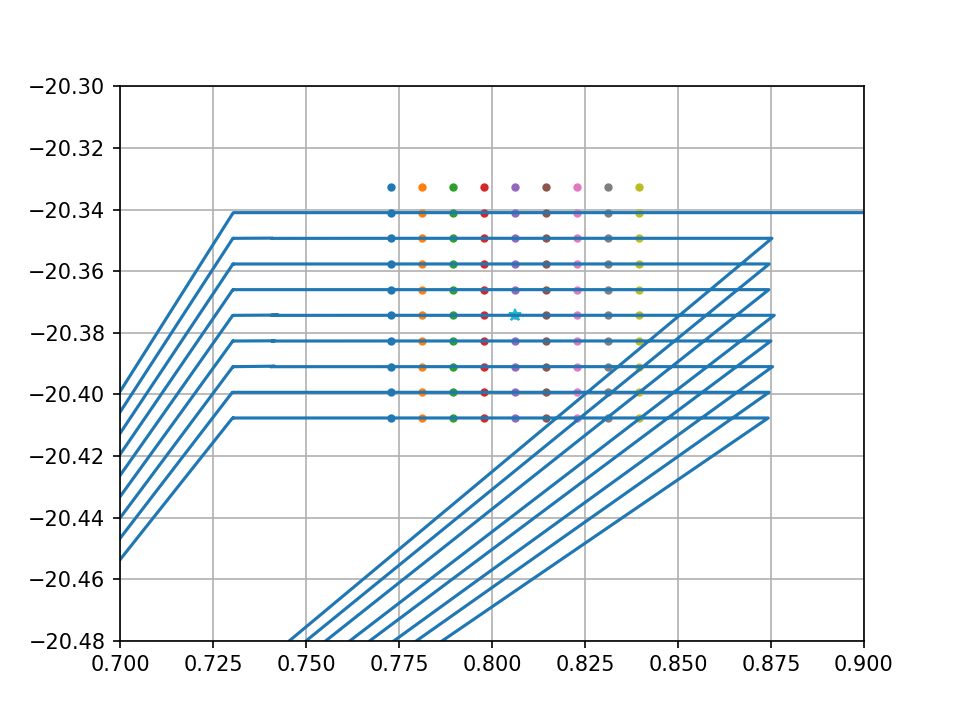

In [111]:
%matplotlib notebook
#gridの確認
#girdとXFFTSの点がずれている。これはプロジェクションの問題でcosがかかっていないからか？
plt.plot(radec_grid[0], radec_grid[1], ".")
plt.plot(lamda_on, beta_on, "*")
plt.plot(xffts[0], xffts[1])
#plt.plot(encoder[0], encoder[1], ".")
plt.xlim(0.7,0.9)
plt.ylim(-20.48, -20.3)
plt.savefig("neko.pdf")
plt.grid()
plt.show()

### なんで線と点がずれているんだ？

In [ ]:
numpy.cos(3.14)
d2r= numpy.deg2rad
numpy.cos(d2r(90))
radec_grid[1]

In [ ]:
xffts[2]

## doppler tracking


In [ ]:
#this will be added
from numpy import deg2rad
d = analy_doppler_nanten.doppler_nanten()
#d.calc_vobs(deg2rad(11), deg2rad(11), time.time())
vobs = [d.calc_vobs(deg2rad(xffts[0][i]),deg2rad(xffts[1][i]), xffts[2][i]) for i in tqdm(range(len(xffts[0])))]
#vobs = Parallel(n_jobs=-1, verbose=2)([delayed(d.calc_vobs(deg2rad(xffts[0][i]), deg2rad(xffts[1][i]), xffts[2][i])) for i in tqdm(range(len(xffts[0])))])

In [ ]:
vobs

### 分光データの読み出し
on/off/hot indexの整理

In [ ]:
%%time
n = n2df.Read(os.path.join(analy_dir, "xffts.ndf"))
array_data = n.read_onearray(array_num)#1IFの分光データ
obs_mode = n.read_obs_mode()#観測モード（ON/OFF/HOT）
scan_num = n.read_scan_num()#スキャンライン（0,1,2,3,4,...）
###array_data, scan_num, obs_mode = n.read_for_otf(1)#3分くらいかかた

In [ ]:
###index探し
obs_mode = numpy.array(obs_mode)
scan_num = numpy.array(scan_num)

offmask = obs_mode == "OFF"
offindex = numpy.where(offmask == True)

hotmask = obs_mode == "HOT"
hotindex = numpy.where(hotmask == True)

onmask = obs_mode == "ON"
onindex = numpy.where(onmask == True)

max_scannum = numpy.max(scan_num)#Caution! scan num starts from 0, so scan number of 26 indicates 27 times scan

In [ ]:
#一応indexの可視化
plt.plot(offindex[0], [1]*len(offindex[0]),"." , label = "off")
plt.plot(hotindex[0], [1]*len(hotindex[0]),"." , label = "hot")
plt.plot(onindex[0], [1]*len(onindex[0]),"." , label = "on")
plt.xlim(0,1000)
plt.legend()
plt.show()

In [ ]:
#OFF 点のscan number を取得
scan_num = numpy.array(scan_num)
print(scan_num)
offindex[0]
plt.plot(scan_num[offindex[0]])
plt.grid()
plt.show()

#HOT 点のscan number を取得
scan_num = numpy.array(scan_num)
hotindex[0]
plt.plot(scan_num[hotindex[0]])
plt.grid()
plt.show()

# ON 点のscan number を取得
scan_num = numpy.array(scan_num)
plt.plot(scan_num[onindex[0]])
plt.grid()
plt.show()

### hot/offの積分

In [ ]:
#HOT積分
print(numpy.unique(scan_num[hotindex[0]]))#HOT のscan number
hotnum = numpy.unique(scan_num[hotindex[0]])#HOTの数

hotdata = []

for i in tqdm(hotnum):#i = scan number
    mask = scan_num == i#特定のscannumのindexを抜き出す
    index = numpy.where(mask == True)#特定のscannumのindex変数
   ### 
    c = numpy.in1d(index[0], hotindex[0])#特定のscannumのindex&HOT index
    c = numpy.where(c == True)[0]
    ###
    mm = index[0][c]#scan numの値でフィルターしたhot
    #print(mm)
    ###積分
    tmp = [array_data[j] for j in mm]
    hotdata.append(sum(tmp)/len(tmp))
    pass

#下は擬似データの質が低いための処理。将来的に削除
hotdata = numpy.array(hotdata)
hotdata = hotdata + 5000

In [ ]:
##OFFの積分
print(numpy.unique(scan_num[offindex[0]]))#HOT のscan number
offnum = numpy.unique(scan_num[offindex[0]])#HOTの数

offdata = []
scan_num = numpy.array(scan_num)

for i in tqdm(offnum):
    mask = scan_num == i#特定のscannumのindexを抜き出す
    index = numpy.where(mask == True)#特定のscannumのindex変数
   ### 
    c = numpy.in1d(index[0], offindex[0])#特定のscannumのindex&HOT index
    c = numpy.where(c == True)[0]#scannumとhotで絞ったindex
    mm = index[0][c]#scan numの値でフィルターしたhot
    tmp = [array_data[j] for j in mm]
    offdata.append(sum(tmp)/len(tmp))

Hot のデータはscan line分あるわけでないので補完
Off もscan line 分ある観測プログラムしかないはずだが、一応補完

補完の方法は次のOFF/HOTの点の観測を行うまでは直近のデータを採用する形

In [ ]:
d = numpy.unique(scan_num[hotindex[0]])#HOT のscan number
hotdata_ = []
count = 0

for i in tqdm(range(max_scannum)):
        #print(i,count)
        if i == d[count]:
            hotdata_.append(d[count])
            count +=1
        elif i < d[count]:
            hotdata_.append(d[count])
        else:#この例外には入らないはず
            print(i)

In [ ]:
d = numpy.unique(scan_num[offindex[0]])#HOT のscan number
offdata_ = []
count = 0

for i in tqdm(range(max_scannum)):
        #print(i,count)
        if i == d[count]:
            offdata_.append(d[count])
            count +=1
        elif i < d[count]:
            offdata_.append(d[count])
        else:#この例外には入らないはず
            print(i)

In [ ]:
# ###Choper wheel

@numba.jit
def chopper_wheel(on_index, scan_num, temprature = 300):    
    #scan_num = n[on_index]["scan_num"]
    #Tastar = (array_data[on_index] - offdata[scan_num])/(hotdata[scan_num] - offdata[scan_num]) * temprature
    Tastar = (array_data[on_index] - offdata[0])/(hotdata[0] - offdata[0]) * temprature#test, this will be deleted（hotdata, offdata[0]しかつかってない！）
    return Tastar

def calc(i):#on点をscan indexでmaskしchopper wheelする
    mask = scan_num == i#特定のscannumのindexを抜き出す
    index = numpy.where(mask == True)#特定のscannumのindex変数
    c = numpy.intersect1d(index[0], onindex[0])
    return [[j, chopper_wheel(j, i, cabin_temp[i])] for j in c]###j= index 

In [ ]:
ondata = [calc(i) for i in tqdm(range(max_scannum+1))]#Chopper Wheelしたやつ

In [ ]:
%%time
data_on = {ondata[i][j][0]:ondata[i][j][1] for i in range(len(ondata)) for j in range(len(ondata[i]))}###d[onindex] = onarray
data_on[4433][16000] += 100000000
print(data_on[4433][16000])

In [ ]:
#距離による重みつけ関数１
#sigma == ビームサイズ
def gauss(x, a = 1, mu = 0, sigma = 160):
    return a * numpy.exp(-(x - mu)**2 / (2*sigma**2))


#距離による重みつけ関数2 関数系わからないので今はgaussianだけど修正
def bessel_gauss(x, a = 1, mu = 0, sigma = 160):
    return a * numpy.exp(-(x - mu)**2 / (2*sigma**2))

#球面なのでRA方向の長さがDECで変わります。なのでRA-DEC平面での距離(角度)を出すには、RAをcos(DEC)で割る必要があります。
def calc_distance(d1, d2):
    #d1 = [ra, dec] #deg   
    factor = 3600#こういうことしなくてもいいようにastropy unitを使う（要編集）
    d1[0] = d1[0]*factor
    d1[1] = d1[1]*factor
    d2[0] = d2[0]*factor
    d2[1] = d2[1]*factor
    return ((d1[0] - d2[0])**2 + (d1[1] - d2[1])**2)**0.5

def calc_rms(arr):
    return numpy.sqrt(numpy.mean(arr**2))

def rms_dist_weighting(arr, dist, rms):
    return [arr*gauss(dist)*(rms**-2), gauss(dist)*(rms**-2)]

## Baseline fitting

In [ ]:
#baseline fitting parameter
center = 8000
width = 1000
start = 3000
end = 30000

#baseline fitting function
def f(x, a, b, c):
    return a*x**2 + b*x + c

def  baseline_fitting(arr_x, arr_y, index1, index2, index3, index4):
    tmpdata_y1 = arr_y[index1:index2]
    tmpdata_y2 = arr_y[index3:index4]
    tmpdata_x1 = arr_x[index1:index2]
    tmpdata_x2 = arr_x[index3:index4]
    x = numpy.concatenate([tmpdata_x1, tmpdata_x2])
    y = numpy.concatenate([tmpdata_y1, tmpdata_y2])
    param = numpy.polyfit(x, y, 2)
    arr_y = arr_y - f(arr_x, *param)
    return arr_y
    
#ch
xindex = numpy.linspace(0, 32768, 32768)

#baseline fitting index
index1 = int(start)
index2 = int(center - width/2)
index3 = int(center + width/2)
index4 = int(end)
print(index1, index2, index3, index4)

testoffset = numpy.linspace(1, 32768, 32768)

for i in tqdm(data_on.keys()):
    data_on[i] = data_on[i] + testoffset#ベースラインフィッティングできているかの確認のため
    origin = data_on[i]#for debug, this will be deleted
    data_on[i] = baseline_fitting(data_on[i], xindex, index1, index2, index3, index4)
    
    
plt.plot(data_on[i], label="after chopper wheel")#after chopper wheel
plt.plot(origin, label="before chopper wheel")#before chopper wheel
plt.legend()
plt.grid()

In [ ]:
#plt.plot(data_on[i], label="after chopper wheel")#after chopper wheel
%matplotlib inline
plt.plot(origin-testoffset, label="before chopper wheel")#before chopper wheel
plt.legend()
plt.grid()

## grid内のデータ探索

あるgridに採用するデータのindexを求める

In [ ]:
%time
index_list = []
for i in tqdm(range(max_scannum)):
    for j in range(max_scannum):
       # print(ragrid[i], decgrid[j])
        index1 = numpy.where((ragrid[i]-(offset/3600)<xffts[0]) & ((ragrid[i] + (offset/3600)>xffts[0])))
        index2 = numpy.where((decgrid[j]-(offset/3600)<xffts[1]) & ((decgrid[j] + (offset/3600)>xffts[1])))
        index_ = [i in index2[0] for i in index1[0]]
        index_ = numpy.array(index_)
        index_1and2 = numpy.where(index_ == True)
        index_1and2 = index1[0][index_1and2]
        index_list.append(index_1and2)


### xfftsデータの確認

### データをgridに入れる

本番はもう少し賢く書くけど、ひとまず

In [ ]:
%%time
#cubeデータの作成
#data_c = numpy.zeros((31, 31, 32768))#(ra, dec, ch)
#index_list2 = numpy.reshape(index_list, (31,31))#index listの2次元化（これは前処理しておく） #これは正しいか？
data_c = numpy.zeros((max_scannum, max_scannum, 32768))#(ra, dec, ch)
index_list2 = numpy.reshape(index_list, (max_scannum, max_scannum))#index listの2次元化（これは前処理しておく） #これは正しいか？

## Chopper wheelしたデータをdatacubeに入れる
for i in tqdm(range(max_scannum)):#ra
    for j in range(max_scannum):#dec
        try:
            numerator_list = []#分子
            denominator_list= []#分母
            for k in index_list2[i][j]:
                dist = calc_distance([ragrid[i], decgrid[j]], [xffts[0][k], xffts[1][k]])
                rms = calc_rms(data_on[k])
                weighted_data = rms_dist_weighting(data_on[k], dist, rms)
                #weighted_data = rms_dist_weighting(data_on[k], dist, 1)###RMSがうまく動いているかの確認
                numerator_list.append(weighted_data[0])
                denominator_list.append(weighted_data[1])
            data_c[i][j] = sum(numerator_list)/sum(denominator_list)
        except Exception as e:
            print("[{},{}], {}".format(i,j,e), end = "")

距離を考慮すると...

### astropyでfitsに書き出す

In [ ]:
#3軸の入れ替え。
data_c = numpy.swapaxes(data_c, 0,2)
print(numpy.shape(data_c))#軸の入れ替えの確認

ヘッダーの作成

In [ ]:
header_dict = {
"object" : obsfile_dict["object"],
"crval1" : obsfile_dict["lambda_on"],
"cdelt1" : obsfile_dict["grid"]/3600,
"crpix1" : obsfile_dict["N"]-1/2,#中心ピクセル
"crval2" : obsfile_dict["beta_on"],
"cdelt2" : obsfile_dict["grid"]/3600,
"crpix2" : obsfile_dict["N"]-1/2 #中心ピクセル
}

In [ ]:
temp = """
SIMPLE  =                    T                                                  
BITPIX  =                  -32                                                  
NAXIS   =                    3                                                  
NAXIS1  =                  31                                                 
NAXIS2  =                  31                                                 
NAXIS3  =                   32768                                                  
OBJECT  = '{object}              '                                                  
TELESCOP= 'NANTEN2            '                                                  
INSTRUME= 'MULT2-11          '                                                  
OBSERVER= 'z7510rk           '                                                  
DATE-OBS= '2007-12-30        '                                                  
DATE-MAP= '2012-01-19        '                                                  
BSCALE  =    0.10000000000E+01                                                  
BZERO   =    0.00000000000E+01                                                  
BUNIT   = 'K                 '                                                  
EPOCH   =    0.20000000000E+04                                                  
OBSRA   =    8.38104170000E+01                                                  
OBSDEC  =   -5.37511100000E+00                                                  
DATAMAX =    1.16774444580E+02                                                  
DATAMIN =   -8.33924560547E+01                                                  
CTYPE1  = 'RA---GLS          '                                                  
CRVAL1  =    {crval1}                                                  
CDELT1  =    {cdelt1}                                                  
CRPIX1  =      {crpix1}
CROTA1  =     0.0000000000E+00                                                  
CTYPE2  = 'DEC--GLS          '                                                  
CRVAL2  =   {crval2}                                                  
CDELT2  =   {cdelt2}                                               
CRPIX2  =     {crpix2}                                               
CROTA2  =     0.0000000000E+00                                                  
CTYPE3  = 'VELO-LSR          '                                                  
CRVAL3  =    2.50000000000E+02                                                  
CDELT3  =    5.00000000000E+02                                                  
CRPIX3  =    1.00000000000E+00                                                  
CROTA3  =    0.00000000000E+00                                                  
BLANK   =   -1.00000000000E+00 """.format(**header_dict)

In [ ]:
target_header = fits.Header.fromstring(temp, sep = "\n")

In [ ]:
#書き出し
hdu = fits.PrimaryHDU(data_c, target_header)
hdulist = fits.HDUList([hdu])
hdulist.writeto("test4.fits", overwrite = True)

In [ ]:
##読み込み
hdu_list = fits.open("test4.fits")
hdu_r = hdu_list[0]
data = hdu_r.data
header = hdu_r.header

In [ ]:
#解析にかかった時間を出すため
print("required time : {}".format(time.time() - start_time))

In [ ]:
#%matplotlib notebook
%matplotlib inline
from ipywidgets import interact

def plot(i):
    plt.figure(figsize=(8, 8))
    plt.imshow(data[i].T, cmap = "gist_rainbow")
    #plt.xlabel("ra")
    #plt.ylabel("dec")
    plt.show()


interact(plot, i = (0,16000,1))

In [ ]:
#bokeh  使い方あんまかしわからん
from bokeh.plotting import figure
from bokeh.io import show, output_notebook

output_notebook()
plt1 = figure()
rend1 = plt1.image(image=[data[16000]], x=0, y=0, dw =31, dh=31, palette="Plasma11")

show(plt1)

In [ ]:
numpy.max(data)

In [ ]:
numpy.where(data > 213)